In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
import confseq
from confseq.conjmix_bounded import *
import multiprocess as mp
from tqdm.notebook import tqdm

In [2]:
from scipy.special import expit

In [3]:
def gen_logit_data(X=None, beta=None, beta_norm=3, var=1, n=1000, d=10, seed=None):
    rng = np.random.default_rng(seed=seed)
    if X is None:
        X = rng.normal(size=(n, d))
    if beta is None:
        beta = rng.normal(size=(d + 1))
        beta = beta / np.linalg.norm(beta) * beta_norm
    coef, bias = beta[:(-1)], beta[-1]
    Y = rng.binomial(1, expit(X.dot(coef) + bias))
    return Y, X, coef, bias

In [4]:
seed = 322
d = 10
train_n = 100
train_Y, train_X, true_coef, true_bias = gen_logit_data(n=100, d=10, seed=seed)
print(true_coef, true_bias)

[ 0.98297473 -1.90200438 -0.34104811  0.58016974 -1.0934589  -0.38466286
  1.13143942 -0.20046086  0.96767645 -0.0155843 ] -0.6021885901714426


(Text(0.5, 0, '$X_1$'), Text(0, 0.5, '$X_2$'))

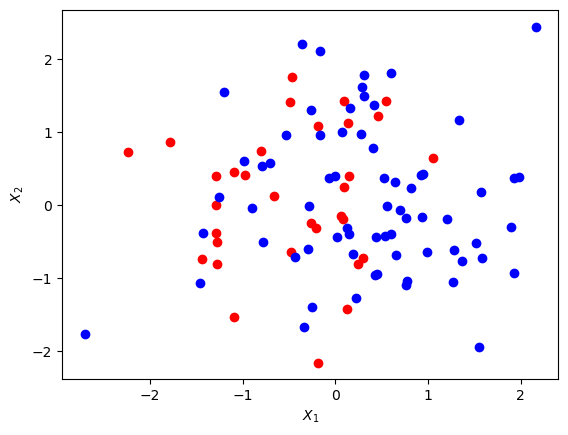

In [5]:
fig, ax = plt.figure(), plt.gca()
ax.scatter(train_X[train_Y == 1, 1], train_X[train_Y == 1, 2], color='red', label='1')
ax.scatter(train_X[train_Y == 0, 1], train_X[train_Y == 0, 2], color='blue', label='0')
ax.set_xlabel('$X_1$'), ax.set_ylabel('$X_2$')

In [6]:
import sklearn
import sklearn.linear_model as sklm

In [7]:
learned_model = sklm.LogisticRegression(penalty=None, random_state=seed)
learned_model.fit(train_X, train_Y)

LogisticRegression(penalty=None, random_state=322)

In [12]:
test_Y, test_X, _, _ = gen_logit_data(beta=np.concatenate([true_coef, np.array(true_bias).reshape(-1)]), n=1000, seed=seed + 1)

In [13]:
print(np.sum(test_Y) / len(test_Y))

0.453


In [14]:
learned_prob = learned_model.predict_proba(test_X)

In [17]:
mc_Y, mc_X, _, _ = gen_logit_data(beta=np.concatenate([true_coef, np.array(true_bias).reshape(-1)]), n=100000, seed=seed + 2)
mc_probs = learned_model.predict_proba(mc_X)

In [18]:
import scipy
import scipy.optimize

(Text(0.5, 0, '$\\beta$'),
 Text(0, 0.5, 'FP'),
 Text(0.5, 1.0, 'Smallest $\\beta$ with FP($\\beta$) $\\leq$ $\\theta$ is 0.502'))

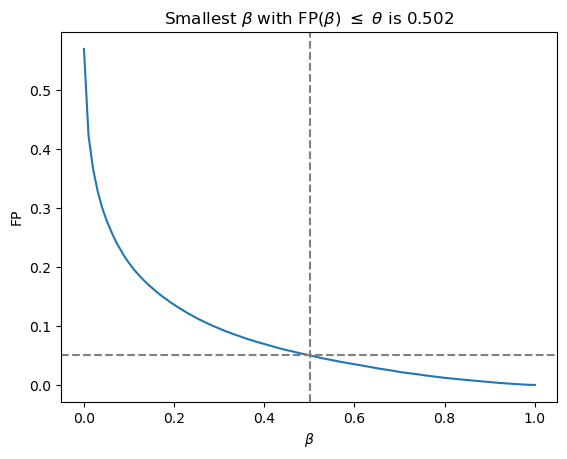

In [19]:
def calc_fp(beta):
    return np.mean((mc_probs[:, 1] > beta).astype(int) * (1 - mc_Y).astype(int))

theta = 0.05
sol = scipy.optimize.root_scalar(lambda beta: calc_fp(beta) - theta, x0=0.5, bracket=(0., 1.))

fig, ax = plt.figure(), plt.gca()
beta_choices = np.linspace(0, 1, 100)
ax.plot(beta_choices, [calc_fp(beta) for beta in beta_choices])
ax.axhline(0.05, color='gray', linestyle='dashed')
ax.axvline(sol.root, color='gray', linestyle='dashed')
ax.set_xlabel('$\\beta$'), ax.set_ylabel('FP'), ax.set_title(f'Smallest $\\beta$ with FP($\\beta$) $\\leq$ $\\theta$ is {sol.root:.3f}')

# Martingale for standard case

In [20]:
def binary_fp_mart_fn(x, beta, **kwargs):
    """Martingale where we let l(X, Y, beta) be the empirical false positive indicator for binary classification.
    
    1 is positive. 0 is negative.
    
    :x: tuple of class probabilities and true class labels
    :beta: parameter in [0, 1]
    :theta: risk control parameter in [0, 1]"""
    fit_prob, Y, theta = x.T
    return confseq.betting.betting_mart(1 * (fit_prob > beta).astype(float) * (1 - Y).astype(float), 1 * theta[0], **kwargs)

def binary_fp_cs(fit_prob, Y, theta, alpha, **kwargs):
    x = np.array([fit_prob, Y, np.full(fit_prob.shape, theta)]).T
    return confseq.betting.cs_from_martingale(x, binary_fp_mart_fn, alpha=alpha, **kwargs)

0.6900037967242785 -1.5078129627443213 2.995732273553991


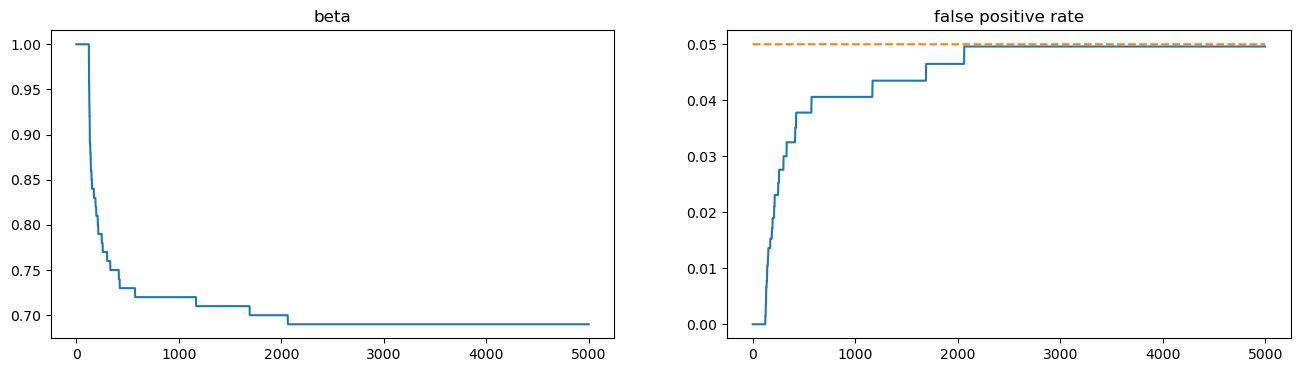

In [21]:
class UpperMartingale:
    def __init__(self, *, rho, rho_max, theta, beta_min, beta_max, delta_beta, alpha):
        from collections import defaultdict
        from math import log
    
        assert rho_max > 0
        assert 0 <= theta <= rho_max
        assert beta_min < beta_max
        assert delta_beta > 0
        assert 0 < alpha < 1
        
        self.rho = rho
        self.rho_max = rho_max
        self.theta = theta
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.delta_beta = delta_beta
        self.alpha = alpha
        
        self.stats = defaultdict(lambda: [0, 0, 0])
        self.curlam = 0
        self.phicurlam = self._phi(self.curlam)
        self.maxlam = 1/(2*rho_max)
        self.curbeta = beta_max
        self.thres = -log(alpha)
        self._updatecurbetatest(max(beta_max - delta_beta, beta_min))
        self.betaminlogwealth = 0
        
    def addobs(self, x):
        self.stats[x][0] += 1
        self.stats[x][1] += self.curlam
        self.stats[x][2] += self.phicurlam
        
        ximin = self.theta - self.rho(x, self.beta_min)
        self.betaminlogwealth += self.curlam * ximin - self.phicurlam * ximin**2
        
        xitest = self.theta - self.rho(x, self.curbetatest)
        self.curbetatestlogwealth += self.curlam * xitest - self.phicurlam * xitest**2
        self.curbetatestnum += xitest
        self.curbetatestdenom += xitest**2
        
        if self.curbetatestnum <= 0:
            self.curlam = 0
        elif self.curbetatestnum <= self.maxlam * (self.curbetatestnum + self.curbetatestdenom):
            self.curlam = self.curbetatestnum / (self.curbetatestnum + self.curbetatestdenom)
        else:
            self.curlam = self.maxlam
            
        self.phicurlam = self._phi(self.curlam)

    def getbeta(self):
        if self.curbetatestlogwealth > self.thres:
            self._updatecs()
        return self.curbeta
    
    def _phi(self, x):
        from math import log1p
        return -x - log1p(-x)
        
    def _updatecurbetatest(self, beta):
        logw, num, denom = 0, 0, 0
        for x, stats in self.stats.items():
            xi = self.theta - self.rho(x, beta)
            logw += stats[1] * xi - stats[2] * xi**2
            num += stats[0] * xi
            denom += stats[0] * xi**2
            
        self.curbetatest = beta
        self.curbetatestlogwealth = logw
        self.curbetatestnum = num
        self.curbetatestdenom = denom       
    
    def _updatecs(self):
        from scipy import optimize as so
        if self.curbetatest <= self.beta_min:
            return
        
        maxbeta = self.curbetatest
        maxbetawealth = self.curbetatestlogwealth
        if maxbetawealth < self.thres:
            return
                
        minbeta = self.beta_min
        minbetawealth = self.betaminlogwealth
        if minbetawealth >= self.thres:
            self.curbeta = self.beta_min
            self._updatecurbetatest(self.beta_min)
            return
        
        def logwealth(beta):
            logw = 0
            for x, stats in self.stats.items():
                xi = self.theta - self.rho(x, beta)
                logw += stats[1] * xi - stats[2] * xi**2
                
            return logw
                        
        res = so.root_scalar(
            f = lambda beta: logwealth(beta)-self.thres, 
            xtol = self.delta_beta/10,
            method = 'brentq',
            bracket = [ minbeta, maxbeta ])
        assert res.converged, res
        self.curbeta = res.root
        self._updatecurbetatest(max(self.curbeta - self.delta_beta, self.beta_min))

        
def upper_mart_cs(fit_prob, Y, theta, alpha):
    def rho(x, beta):
        p, Y = x
        return (p >= beta) * (1 - Y)
    
    cs = UpperMartingale(rho=rho, rho_max=1, theta=theta, beta_min=0, beta_max=1, delta_beta=1e-3, alpha=alpha)
        
    rv = []
    for p, Y in zip(fit_prob, Y):
        cs.addobs((p, Y))
        rv.append(cs.getbeta())
    return rv
    
    
def test_once(gen, n_max):
    # p is the true probability of a positive 
    # our decision is 1_{beta <= p}
    # if beta > p we say negative so no risk
    # if beta <= p then we have a false positive with probability (1 - p)
    
    def rho(p, beta):
        return 0 if beta > p else (1 - p)
    
    cs = UpperMartingale(rho=rho, rho_max=1, theta=0.05, beta_min=0, beta_max=1, delta_beta=1e-3, alpha=0.05)
        
    rv = []
        
    for n in range(n_max):
        p = round(gen.uniform(), 2)
        cs.addobs(p)
        rv.append(cs.getbeta())
        
    print(cs.curbeta, cs.curbetatestlogwealth, cs.thres)

    return rv
        
def test():
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 4)
    
    gen = np.random.default_rng(1)
    curve = test_once(gen, 5000)
    ax1.plot(curve, label='beta')
    ax1.title.set_text('beta')
    
    truefp = lambda z: (100 - int(z)) * (101 - int(z)) / 20_000
    ax2.plot([ truefp(100*beta) for beta in curve ], label='truefp')
    ax2.plot([ 0.05 for beta in curve ], linestyle='dashed')
    ax2.title.set_text('false positive rate')
    
test()

In [27]:
cs_test = binary_fp_cs(learned_prob[:, 1], test_Y, theta=0.05, alpha=0.05 * 2)

In [28]:
um_cs_test = upper_mart_cs(learned_prob[:, 1], test_Y, theta=0.05, alpha=0.05 * 2)

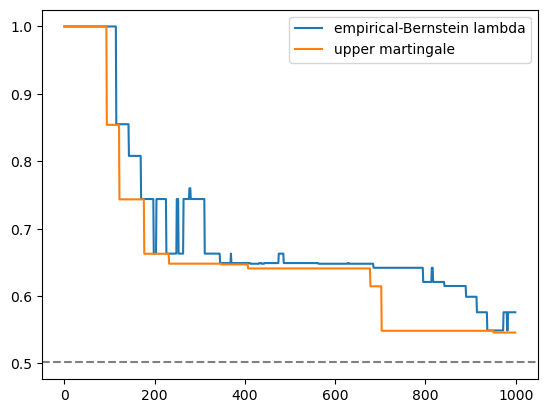

In [29]:
fig, ax = plt.figure(), plt.gca()
ax.plot(np.arange(len(cs_test[1])), cs_test[1], label='empirical-Bernstein lambda')
ax.plot(np.arange(len(cs_test[1])), um_cs_test, label='upper martingale')
ax.axhline(sol.root, color='gray', linestyle='dashed')
ax.legend()

# Active labeled martingale

In [31]:
def active_binary_fp_mart_fn(x, beta, alpha, q_max, **kwargs):
    """Martingale where we let l(X, Y, beta) be the empirical false positive indicator for binary classification.
    
    1 is positive. 0 is negative.
    
    :x: tuple of class probabilities and true class labels
    :beta: parameter in [0, 1]
    :theta: risk control parameter in [0, 1]"""
    fit_prob, Y, q, ind, theta = x.T
    r = (fit_prob > beta).astype(float) * (1 - Y).astype(float) # bounded between 0 and 1
    ipw_outcomes = (ind / q) * r
    # print(ipw_outcomes[:10])
    lams = confseq.betting_strategies.lambda_predmix_eb(ipw_outcomes, truncation=q_max, alpha=alpha)
    diffs = theta[0] - ipw_outcomes # theta also bounded between 0 and 1
    
    mart = np.cumprod(1 + lams * diffs)
    
    return mart

def active_binary_fp_cs(fit_prob, Y, q, ind, theta, alpha, q_max, **kwargs):
    x = np.array([fit_prob, Y, q, ind, np.full(fit_prob.shape, theta)]).T
    return confseq.betting.cs_from_martingale(x, lambda x, m: active_binary_fp_mart_fn(x, m, alpha=alpha, q_max=q_max), \
                                              alpha=alpha, **kwargs)

def rand_policy(fit_prob, Y, theta, alpha, budget: float, seed=None):
    q = np.full(fit_prob.shape, budget)
    rng = np.random.default_rng(seed)
    return q, rng.binomial(1, q)



def reward_fn(r, q, ind, theta, lam):
    return np.log(1 + lam * (theta - (ind * r / q)))

import torch


def lagrange_loss(q, gamma, B, theta, reward): 
    return torch.log(1 + lam * (theta - reward)) + gamma * (q - B)
"""
def make_reward( 


def label_policy_cs(X, Y, ell, theta, alpha, budget, seed=None):
    
    gamma = torch.autograd.Variable()
    q = torch.autograd.Variable()
    
    # for i, (x, y) in enumerate(zip(X, Y)):
"""

'\ndef make_reward( \n\n\ndef label_policy_cs(X, Y, ell, theta, alpha, budget, seed=None):\n    \n    gamma = torch.autograd.Variable()\n    q = torch.autograd.Variable()\n    \n    # for i, (x, y) in enumerate(zip(X, Y)):\n'

In [32]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F


## Policy classes

In [34]:
class Policy:
    def get_q_var(self, x):
        pass
    def give_feedback(self, y):
        pass
    
    def set_dual_max(self, dual_max):
        pass

class BaseRatePolicy(Policy):
    def __init__(self, q: float):
        super(BaseRatePolicy, self).__init__()
        self.q = torch.nn.init.constant_(torch.empty(1), q)
    def get_q_var(self, x):
        return self.q
    
def step_optimizer(loss, optimizer):
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

def bin_features(x, coef, bias, d):
    p = expit(x.dot(coef) + bias)
    one_hots = np.zeros(shape=(x.shape[0], d))
    one_hots[:, np.floor(p * d).astype(int)] = 1.
    return one_hots

class LogReg(torch.nn.Module):
    def __init__(self, featurizer, d):
        super(LogReg, self).__init__()
        self.featurizer = featurizer
        self.beta = torch.nn.Linear(d, 1)
        
    def forward(self, x):
        return F.sigmoid(self.beta(torch.tensor(self.featurizer(x)).float()))

class DiffPolicy(Policy):
    def __init__(self, predictor_model, optimizer_fn, budget, q_min, dual_mode='best_response', \
                 dual_optimizer_fn=None, dual_max=None):
        assert dual_mode == 'best_response' and dual_max is not None or dual_optimizer_fn is not None
        
        self.predictor_model = predictor_model
        self.q_min = q_min
        self.optimizer = optimizer_fn(predictor_model.parameters())
        
        self.dual_mode = dual_mode
        self.dual_v = torch.tensor(0., requires_grad=True)
        if dual_optimizer_fn is not None:
            self.dual_optimizer = dual_optimizer_fn([dual_v])
        self.dual_max = dual_max
        
    def set_dual_max(self, dual_max):
        self.dual_max = dual_max
        
    def get_q_var(self, x):
        return self.q_min + (1 - self.q_min) * self.predictor_model.forward(x)
    
    def get_feedback(self, util, x=None, q_var=None):
        if q_var is None:
            q_var = self.get_q_var(x.reshape(1, -1))    
        
        if dual_mode == 'best_response':
            self.dual_v.data = dual_max if q_var.data > self.budget else 0
        else:
            dual_loss = self.dual_v * (self.budget - q_var)
            if dual_mode == 'be_the_leader':
                step_optimizer(dual_loss, self.dual_optimizer)
        primal_loss = -util + self.dual_v * q_var
        step_optimizer(primal_loss, self.optimizer)
        
        if dual_mode == 'follow_the_leader':
            step_optimizer(dual_loss, self.dual_optimizer)
        
    

## Iterative Active Martingale implementation

In [35]:
class ActiveUpperMartingale:
    def __init__(self, *, rho, rho_max, q_min, theta, beta_min, beta_max, delta_beta, budget, model, alpha):
        from collections import defaultdict
        from math import log
    
        assert rho_max > 0
        assert 0 <= theta <= rho_max
        assert beta_min < beta_max
        assert delta_beta > 0
        assert 0 < alpha < 1
        
        self.rho = lambda x, y, beta: 0 if y is None else rho(x, y, beta)
        self.rho_max = rho_max
        self.theta = theta
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.delta_beta = delta_beta
        self.alpha = alpha
        self.q_min = q_min
        
        self.stats = defaultdict(lambda: [0, 0, 0])
        self.curlam = 0
        self.phicurlam = self._phi(self.curlam)
        self.maxlam = q_min/(2*rho_max)
        self.curbeta = beta_max
        self.thres = -log(alpha)
        self._updatecurbetatest(max(beta_max - delta_beta, beta_min))
        self.betaminlogwealth = 0
        self.dual_max = (self.maxlam * self.rho_max + self.maxlam * (self.rho_max / self.q_min) + \
                        self._phi(self.maxlam) * np.square(self.rho_max * (1 - 1 / self.q_min))) / budget
        
        self.model = model
        self.model.set_dual_max(self.dual_max)
        
        
    def _log_wealth(self, lam, phi_lam, diff_var: torch.autograd.Variable):
        return lam * diff_var - phi_lam * torch.square(diff_var)
    
    def addobs(self, score, y, x=None, q=None):
        """add observation
        :param score: score (i.e., 1d param) we're trying to calibrate
        :param x: covariate
        :param q: probability of labeling this point
        :param y: true label - None if we didn't get it
        """
        assert q is None or q >= self.q_min
        
        q_val = q if q is not None else q.data
        
        
        self.stats[(score, y, q)][0] += 1
        self.stats[(score, y, q)][1] += self.curlam
        self.stats[(score, y, q)][2] += self.phicurlam
        
        ximin = self.theta - self.rho(score, y, self.beta_min) / q_val
        self.betaminlogwealth += self.curlam * ximin - self.phicurlam * ximin**2
        
        if q is None:
            risk = self.rho(score, y, self.curbetatest)
            q_var = self.model.get_q_var(x.reshape(1, -1))
            diff_var = self.theta - risk / q_var
            log_wealth_var = self._log_wealth(self.cur_lam, self.phicurlam, diff_var)
            xitest = diff_var.data
            self.curbetatestlogwealth += log_wealth_var.data
            # update the model w/ feedback
            self.model.get_feedback(log_wealth_var, q_var=q_var)
        else:
            xitest = self.theta - self.rho(score, y, self.curbetatest) / q
            # print(xitest.shape, self.curbetatest, score.shape, y.shape)
            self.curbetatestlogwealth += self.curlam * xitest - self.phicurlam * xitest**2

            
        self.curbetatestnum += xitest
        self.curbetatestdenom += xitest**2

        if self.curbetatestnum <= 0:
            self.curlam = 0
        elif self.curbetatestnum <= self.maxlam * (self.curbetatestnum + self.curbetatestdenom):
            self.curlam = self.curbetatestnum / (self.curbetatestnum + self.curbetatestdenom)
        else:
            self.curlam = self.maxlam

        self.phicurlam = self._phi(self.curlam)
    
    def getq(self, x):
        return self.model.get_q_var(x.reshape(1, -1)).item()
    
    def getbeta(self):
        if self.curbetatestlogwealth > self.thres:
            self._updatecs()
        return self.curbeta
    
    def _phi(self, x):
        from math import log1p
        return -x - log1p(-x)
        
    def _updatecurbetatest(self, beta):
        logw, num, denom = 0, 0, 0
        for (score, y, q), stats in self.stats.items():
            xi = self.theta - self.rho(score, y, beta) / q
            logw += stats[1] * xi - stats[2] * xi**2
            num += stats[0] * xi
            denom += stats[0] * xi**2
            
        self.curbetatest = beta
        self.curbetatestlogwealth = logw
        self.curbetatestnum = num
        self.curbetatestdenom = denom       
    
    def _updatecs(self):
        from scipy import optimize as so
        if self.curbetatest <= self.beta_min:
            return
        
        maxbeta = self.curbetatest
        maxbetawealth = self.curbetatestlogwealth
        if maxbetawealth < self.thres:
            return
                
        minbeta = self.beta_min
        minbetawealth = self.betaminlogwealth
        if minbetawealth >= self.thres:
            self.curbeta = self.beta_min
            self._updatecurbetatest(self.beta_min)
            return
        
        def logwealth(beta):
            logw = 0
            for (x, y, q), stats in self.stats.items():
                xi = self.theta - self.rho(x, y, beta) / q
                logw += stats[1] * xi - stats[2] * xi**2
                
            return logw
                        
        res = so.root_scalar(
            f = lambda beta: logwealth(beta)-self.thres, 
            xtol = self.delta_beta/10,
            method = 'brentq',
            bracket = [minbeta, maxbeta])
        assert res.converged, res
        self.curbeta = res.root
        self._updatecurbetatest(max(self.curbeta - self.delta_beta, self.beta_min))

def default_rho(score, y, beta):
    return (score >= beta) * (1 - y)
           
def active_upper_mart_cs(scores, ys, theta, alpha, budget, model, xs=None, rho=default_rho, q_min=1, seed=None):
    rng = np.random.default_rng(seed=seed)
    
    cs = ActiveUpperMartingale(rho=rho, rho_max=1, theta=theta, beta_min=0, beta_max=1, delta_beta=1e-3, q_min=q_min, \
                               alpha=alpha, budget=budget, model=model)
        
    rv = []
    qs = []
    did_labels = []
    
    if xs is None:
        xs = [np.array(score).reshape(1, 1) for score in scores]
    for x, score, y in zip(xs, scores, ys):
        # print(x, score, y)
        q = cs.getq(x)
        qs.append(q)
        did_label = rng.binomial(1, q)
        cs.addobs(score=score, q=q, x=x, y=y if did_label else None)
        did_labels.append(did_label)
        rv.append(cs.getbeta())
    return rv, qs, did_labels
    

## Simulations

In [36]:
budget = 0.8
q_min = 0.2

In [45]:
names = ['Baseline Act.', 'LogReg Act.']
cses = []

active_cs, qs, did_labels = active_upper_mart_cs(scores=learned_prob[:, 1], \
                                                 ys=test_Y, theta=0.05, alpha=0.05 * 2, 
                                                 budget=budget, q_min=q_min, model=BaseRatePolicy(budget), seed=323)
print(np.mean(qs))
cses.append(active_cs)
# cses.append(upper_mart_cs(scores=learned_prob[:, 1], ys=test_Y, theta=0.05, alpha=0.05 * 2))

0.800000011920929


How well did our online learner learn the correct probability weights?
0.6181536831259727
Probs under each bin tensor([[0.5012, 0.5710, 0.5676, 0.5393, 0.5216, 0.5310, 0.5763, 0.4970, 0.5086,
         0.5027]])
Approx correct probs [0.31622777 0.4472136  0.54772256 0.63245553 0.70710678 0.77459667
 0.83666003 0.89442719 0.9486833  1.        ]


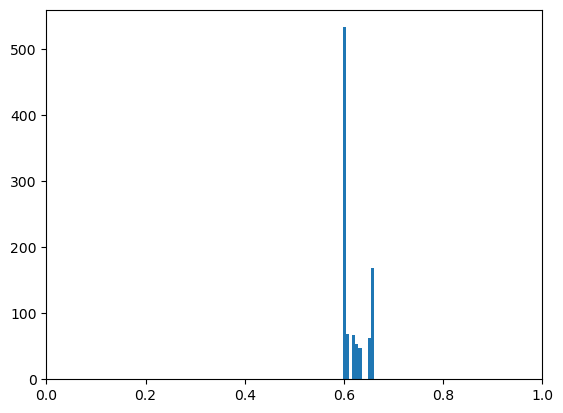

In [56]:
lr_model = LogReg(lambda x: bin_features(x, true_coef, true_bias, d=10), d=10)
diff_policy = DiffPolicy(lr_model, torch.optim.Adam, budget=budget, q_min=q_min, dual_mode='best_response', dual_max=1)

active_cs, qs, did_labels = active_upper_mart_cs(scores=learned_prob[:, 1], \
                                                 ys=test_Y, xs=test_X, theta=0.05, alpha=0.05 * 2, 
                                                 budget=budget, q_min=q_min, model=diff_policy, seed=323)
print("How well did our online learner learn the correct probability weights?")
print('Average q', np.mean(qs))
print('Probs under each bin', expit(lr_model.beta.weight.data + lr_model.beta.bias.data))
print('Approx correct probs', np.sqrt(np.arange(0.1, 1.1, 0.1)))
fig, ax = plt.figure(), plt.gca()
ax.hist(qs)
ax.set_xlim((0, 1))
cses.append(active_cs)

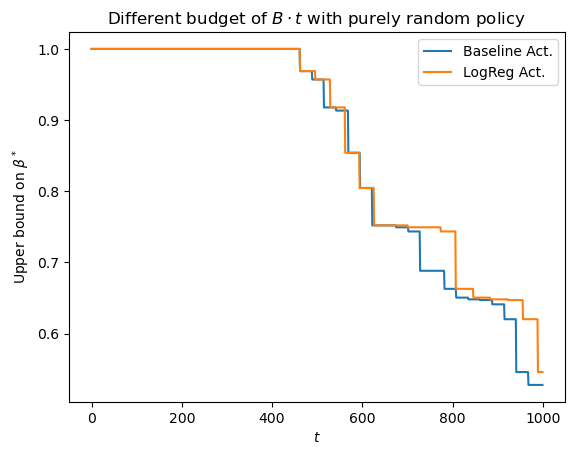

In [47]:
fig, ax = plt.figure(), plt.gca()
for name, cs in zip(names, cses):
    ax.plot(np.arange(len(cs)), cs, label=name)
#ax.plot(np.arange(len(active_cs)), active_cs, label='active cs test')
ax.set_ylabel('Upper bound on $\\beta^*$'), ax.set_xlabel('$t$')
ax.set_title('Different budget of $B \cdot t$ with purely random policy')
ax.legend()